# Conhecendo a base

O diabetes é uma doença crônica grave na qual os indivíduos perdem a capacidade de regular efetivamente os níveis de glicose no sangue e pode levar a uma redução na qualidade de vida e na expectativa de vida.

O Sistema de Vigilância de Fatores de Risco Comportamentais (BRFSS) é uma pesquisa telefônica relacionada à saúde que é coletada anualmente pelo CDC (Centro de Controle e Prevenção de Doenças dos Estados Unidos). A cada ano, a pesquisa coleta respostas de milhares de americanos sobre comportamentos de risco relacionados à saúde, condições crônicas de saúde e o uso de serviços preventivos. Para este projeto, foi utilizado conjunto de dados disponível no Kaggle para o ano de 2015. 

https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset

A FAZER: Procure sempre explicar todas as etapas com células markdown

In [1]:
import pandas as pd
import matplotlib.pylab as plt
import numpy as np
import seaborn as sns

from matplotlib.ticker import PercentFormatter
from scipy.stats import kstest, norm
from scipy.stats import chi2_contingency

# funções desenvolvidas para o projeto
from src.estatistica import (analise_tteste_ind,
                            analise_mannwhitneyu,
                            analise_levene,
                            remove_outliers,
                            )

from src.config import DADOS_TRATADOS

df_diabetes_tratado = pd.read_parquet(DADOS_TRATADOS)

df_diabetes_tratado.head()

,Diabetes,PressaoAlta,ColesterolAlto,ColesterolExame,IMC,Fumante,AVC,ProblemaCardiaco,AtividadeFisica,ComeFrutas,...,PlanoSaude,SemDinheiroConsultas,SaudeGeral,DiasProblemasMentais,DiasProblemasFisicos,DificuldadeAndar,Genero,FaixaIdade,Ensino,FaixaRenda
0,Não,Sim,Não,Sim,26,Não,Não,Não,Sim,Não,...,Sim,Não,Boa,5,30,Não,Masculino,35-39,Faculdade +,< $80.000
1,Não,Sim,Sim,Sim,26,Sim,Sim,Não,Não,Sim,...,Sim,Não,Boa,0,0,Não,Masculino,75-79,Faculdade +,< $80.000
2,Não,Não,Não,Sim,26,Não,Não,Não,Sim,Sim,...,Sim,Não,Excelente,0,10,Não,Masculino,80,Faculdade +,< $80.000
3,Não,Sim,Sim,Sim,28,Sim,Não,Não,Sim,Sim,...,Sim,Não,Boa,0,3,Não,Masculino,70-74,Faculdade +,< $80.000
4,Não,Não,Não,Sim,29,Sim,Não,Não,Sim,Sim,...,Sim,Não,Muito Boa,0,0,Não,Feminino,55-59,Faculdade inc. ou Técnico,< $80.000


In [2]:
colunas_numericas = df_diabetes_tratado.select_dtypes(include="number").columns.to_list()

coluna_alvo = "Diabetes"

colunas_categoricas = df_diabetes_tratado.select_dtypes(include="category").columns.to_list()
colunas_categoricas.remove(coluna_alvo)

colunas_binarias = df_diabetes_tratado.nunique()[df_diabetes_tratado.nunique() == 2].index.to_list()
colunas_binarias.remove(coluna_alvo)

colunas_nao_binarias = list(set(colunas_categoricas) - set(colunas_binarias))

In [3]:
print(colunas_numericas)

['IMC', 'DiasProblemasMentais', 'DiasProblemasFisicos']


In [4]:
coluna_alvo

'Diabetes'

In [5]:
colunas_categoricas

['PressaoAlta',
 'ColesterolAlto',
 'ColesterolExame',
 'Fumante',
 'AVC',
 'ProblemaCardiaco',
 'AtividadeFisica',
 'ComeFrutas',
 'ComeLegumes',
 'ConsumoBebidaAlcoolica',
 'PlanoSaude',
 'SemDinheiroConsultas',
 'SaudeGeral',
 'DificuldadeAndar',
 'Genero',
 'FaixaIdade',
 'Ensino',
 'FaixaRenda']

In [6]:
colunas_binarias

['PressaoAlta',
 'ColesterolAlto',
 'ColesterolExame',
 'Fumante',
 'AVC',
 'ProblemaCardiaco',
 'AtividadeFisica',
 'ComeFrutas',
 'ComeLegumes',
 'ConsumoBebidaAlcoolica',
 'PlanoSaude',
 'SemDinheiroConsultas',
 'DificuldadeAndar',
 'Genero']

In [7]:
colunas_nao_binarias

['FaixaRenda', 'Ensino', 'FaixaIdade', 'SaudeGeral']

# Variáveis numéricas

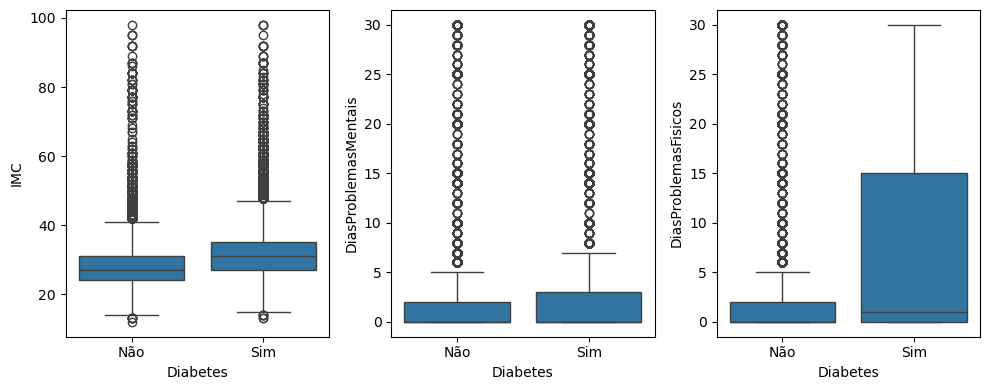

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

for ax, coluna in zip(axs, colunas_numericas):
    sns.boxplot(data=df_diabetes_tratado, x=coluna_alvo, y=coluna, ax=ax)

plt.tight_layout()
plt.show()


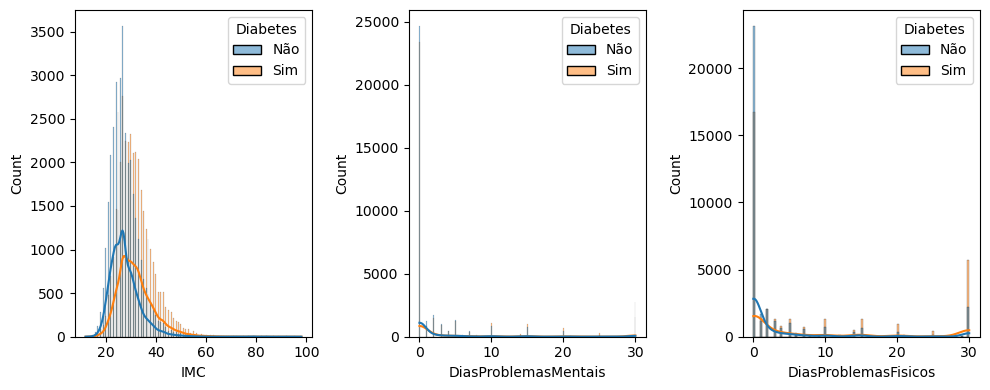

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

for ax, coluna in zip(axs, colunas_numericas):
    sns.histplot(data=df_diabetes_tratado, x=coluna, hue=coluna_alvo, kde=True, ax=ax)

plt.tight_layout()
plt.show()

* atenção para os dados de IMC terem sido aredondados para inteiros
* será que consideerar que há diferença entre diabéticos e não diabéticos considerando IMC?

In [10]:
df_diabetes_tratado.groupby(coluna_alvo, observed=False).describe().T

Diabetes                             Não           Sim
IMC                  count  35346.000000  35346.000000
                     mean      27.769960     31.944011
                     std        6.187636      7.363401
                     min       12.000000     13.000000
                     25%       24.000000     27.000000
                     50%       27.000000     31.000000
                     75%       31.000000     35.000000
                     max       98.000000     98.000000
DiasProblemasMentais count  35346.000000  35346.000000
                     mean       3.042268      4.461806
                     std        7.208408      8.947717
                     min        0.000000      0.000000
                     25%        0.000000      0.000000
                     50%        0.000000      0.000000
                     75%        2.000000      3.000000
                     max       30.000000     30.000000
DiasProblemasFisicos count  35346.000000  35346.000000
                     mean       3.666355      7.954479
                     std        8.098339     11.301491
                     min        0.000000      0.000000
                     25%        0.000000      0.000000
                     50%        0.000000      1.000000
                     75%        2.000000     15.000000
                     max       30.000000     30.000000

In [11]:
df_diabetes_tratado.corr(numeric_only=True)

,IMC,DiasProblemasMentais,DiasProblemasFisicos
IMC,1.000000,0.104682,0.161862
DiasProblemasMentais,0.104682,1.000000,0.380272
DiasProblemasFisicos,0.161862,0.380272,1.000000


* teste t de Student para comparar médias de IMC entre diabéticos e não diabéticos?
* ou teste de Mann-Whitney U para comparar medianas de IMC entre diabéticos e não diabéticos?

### Faz sentido testar a normalidade das variáveis numéricas?

In [12]:
df_diabetes_tratado.groupby(coluna_alvo, observed=False).skew(numeric_only=True)

,IMC,DiasProblemasMentais,DiasProblemasFisicos
Diabetes,,,
Não,2.231015,2.808070,2.480202
Sim,1.527018,2.065169,1.150047


In [13]:
df_diabetes_tratado.groupby(coluna_alvo, observed=False)[colunas_numericas].apply(pd.DataFrame.kurtosis)

,IMC,DiasProblemasMentais,DiasProblemasFisicos
Diabetes,,,
Não,12.901012,7.012218,4.910598
Sim,5.717382,2.873176,-0.341922


In [14]:
df_diabetes_tratado.query("Diabetes == 'Não'")["IMC"].values

array([26, 26, 26, ..., 24, 53, 20], shape=(35346,), dtype=int8)

In [15]:
dados_imc_sim = df_diabetes_tratado.query("Diabetes == 'Sim'")["IMC"].values
dados_imc_nao = df_diabetes_tratado.query("Diabetes == 'Não'")["IMC"].values

In [16]:
print(kstest(dados_imc_nao, norm.cdf, args=(dados_imc_nao.mean(), dados_imc_nao.std())))

print(kstest(dados_imc_sim, norm.cdf, args=(dados_imc_sim.mean(), dados_imc_sim.std())))

KstestResult(statistic=np.float64(0.1209153634702329), pvalue=np.float64(0.0), statistic_location=np.int8(28), statistic_sign=np.int8(1))
KstestResult(statistic=np.float64(0.10452803408478695), pvalue=np.float64(0.0), statistic_location=np.int8(33), statistic_sign=np.int8(1))


In [17]:
dataframe_imc = pd.DataFrame({"Sim":dados_imc_sim, "Não":dados_imc_nao})
dataframe_imc

,Sim,Não
0,30,26
1,25,26
2,28,26
3,23,28
4,27,29
...,...,...
35341,37,23
35342,29,29
35343,25,24
35344,18,53


In [18]:
analise_levene(dataframe=dataframe_imc, centro="median")

Teste de Levene
estatistica_levene = 888.297
Ao menos uma variância é diferente (valor p: 0.000)


In [19]:
analise_tteste_ind(dataframe=dataframe_imc, variancias_iguais=False)

Teste de t Students - ttest_ind
estatistica_tteste = 81.591
Rejita a hipótese nula (valor p: 0.000)


In [20]:
analise_mannwhitneyu(dataframe=dataframe_imc)

Teste de MannWhitney
estatistica_mannwhitneyu = 861173484.000
Rejita a hipótese nula (valor p: 0.000)


### Os outliers interferem?

In [21]:
df_diabetes_sem_outliers = df_diabetes_tratado.copy()

for coluna in colunas_numericas:
    df_diabetes_sem_outliers[coluna] = remove_outliers(df_diabetes_sem_outliers[coluna])

df_diabetes_sem_outliers.describe()

,IMC,DiasProblemasMentais,DiasProblemasFisicos
count,68511.000000,58876.000000,60068.000000
mean,29.129673,0.526615,1.880619
std,5.695466,1.271375,3.727202
min,13.000000,0.000000,0.000000
25%,25.000000,0.000000,0.000000
50%,28.000000,0.000000,0.000000
75%,33.000000,0.000000,2.000000
max,45.000000,5.000000,15.000000


In [22]:
df_diabetes_sem_outliers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70692 entries, 0 to 70691
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   Diabetes                70692 non-null  category
 1   PressaoAlta             70692 non-null  category
 2   ColesterolAlto          70692 non-null  category
 3   ColesterolExame         70692 non-null  category
 4   IMC                     68511 non-null  float64 
 5   Fumante                 70692 non-null  category
 6   AVC                     70692 non-null  category
 7   ProblemaCardiaco        70692 non-null  category
 8   AtividadeFisica         70692 non-null  category
 9   ComeFrutas              70692 non-null  category
 10  ComeLegumes             70692 non-null  category
 11  ConsumoBebidaAlcoolica  70692 non-null  category
 12  PlanoSaude              70692 non-null  category
 13  SemDinheiroConsultas    70692 non-null  category
 14  SaudeGeral            

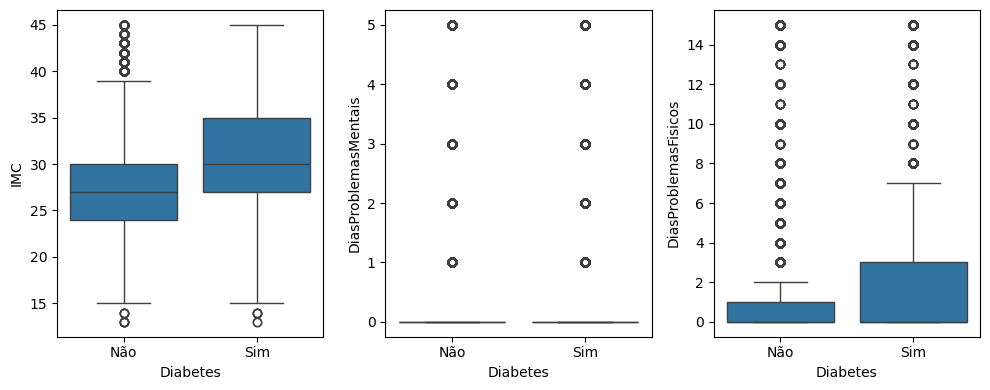

In [23]:
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

for ax, coluna in zip(axs, colunas_numericas):
    sns.boxplot(data=df_diabetes_sem_outliers, x=coluna_alvo, y=coluna, ax=ax)

plt.tight_layout()
plt.show()

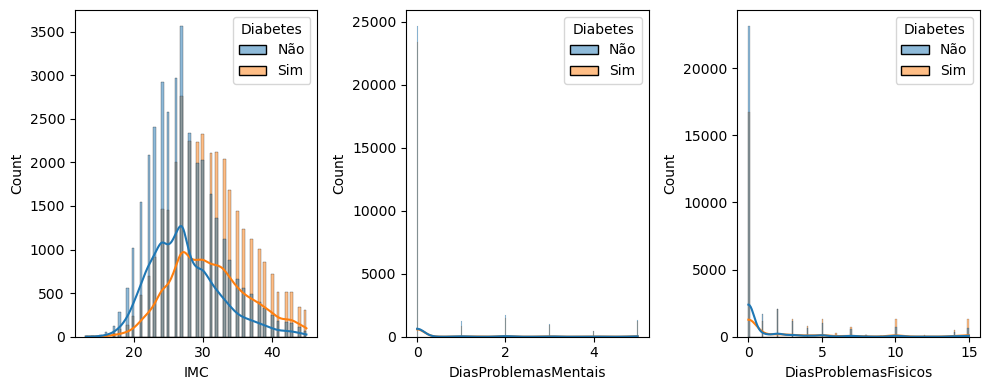

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

for ax, coluna in zip(axs, colunas_numericas):
    sns.histplot(data=df_diabetes_sem_outliers, x=coluna, hue=coluna_alvo, kde=True, ax=ax)

plt.tight_layout()
plt.show()

In [25]:
df_diabetes_sem_outliers.groupby(coluna_alvo, observed=False).skew(numeric_only=True)

,IMC,DiasProblemasMentais,DiasProblemasFisicos
Diabetes,,,
Não,0.714415,2.454599,2.874805
Sim,0.323244,2.507093,1.856026


In [26]:
df_diabetes_sem_outliers.groupby(coluna_alvo, observed=False)[colunas_numericas].apply(pd.DataFrame.kurt)

,IMC,DiasProblemasMentais,DiasProblemasFisicos
Diabetes,,,
Não,0.481335,5.003764,8.079214
Sim,-0.343434,5.185706,2.367289


In [27]:
dados_imc_sim_sem_outliers = df_diabetes_sem_outliers.query("Diabetes == 'Sim'")["IMC"].values
dados_imc_nao_sem_outliers = df_diabetes_sem_outliers.query("Diabetes == 'Não'")["IMC"].values

dataframe_imc_sem_outliers = pd.DataFrame({"Sim":dados_imc_sim_sem_outliers, "Não":dados_imc_nao_sem_outliers})
dataframe_imc_sem_outliers

,Sim,Não
0,30.0,26.0
1,25.0,26.0
2,28.0,26.0
3,23.0,28.0
4,27.0,29.0
...,...,...
35341,37.0,23.0
35342,29.0,29.0
35343,25.0,24.0
35344,18.0,NaN


In [28]:
print(kstest(dataframe_imc_sem_outliers["Não"], norm.cdf, args=(dataframe_imc_sem_outliers["Não"].mean(), dataframe_imc_sem_outliers["Não"].std()), nan_policy="omit"))

print(kstest(dataframe_imc_sem_outliers["Sim"], norm.cdf, args=(dataframe_imc_sem_outliers["Sim"].mean(), dataframe_imc_sem_outliers["Sim"].std()), nan_policy="omit"))

KstestResult(statistic=np.float64(0.10815079726309146), pvalue=np.float64(0.0), statistic_location=np.float64(27.0), statistic_sign=np.int8(1))
KstestResult(statistic=np.float64(0.07345716240963396), pvalue=np.float64(2.3370072025339465e-158), statistic_location=np.float64(30.0), statistic_sign=np.int8(1))


In [29]:
print(
    kstest(
        dataframe_imc_sem_outliers["Não"],
           norm.cdf,
           args=(dataframe_imc_sem_outliers["Não"].mean(),
                 dataframe_imc_sem_outliers["Não"].std()),
                 nan_policy="omit"
            )
    )

print(
    kstest(
        dataframe_imc_sem_outliers["Sim"],
        norm.cdf,
        args=(dataframe_imc_sem_outliers["Sim"].mean(),
              dataframe_imc_sem_outliers["Sim"].std()),
              nan_policy="omit"
            )
    )

KstestResult(statistic=np.float64(0.10815079726309146), pvalue=np.float64(0.0), statistic_location=np.float64(27.0), statistic_sign=np.int8(1))
KstestResult(statistic=np.float64(0.07345716240963396), pvalue=np.float64(2.3370072025339465e-158), statistic_location=np.float64(30.0), statistic_sign=np.int8(1))


In [30]:
analise_levene(dataframe=dataframe_imc_sem_outliers, centro="median")

Teste de Levene
estatistica_levene = 532.986
Ao menos uma variância é diferente (valor p: 0.000)


In [31]:
analise_tteste_ind(dataframe=dataframe_imc_sem_outliers, variancias_iguais=False)

Teste de t Students - ttest_ind
estatistica_tteste = 85.248
Rejita a hipótese nula (valor p: 0.000)


In [32]:
analise_mannwhitneyu(dataframe=dataframe_imc_sem_outliers)

Teste de MannWhitney
estatistica_mannwhitneyu = 801702843.000
Rejita a hipótese nula (valor p: 0.000)


Links e artigos sobre testes de hipótese em datasets grandes:

- https://stats.stackexchange.com/questions/2492/is-normality-testing-essentially-useless
- https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3693611/pdf/ijem-10-486.pdf
- https://www.bmj.com/content/bmj/310/6975/298.full.pdf
- https://bmcmedresmethodol.biomedcentral.com/articles/10.1186/1471-2288-12-81

# Variáveis categóricas

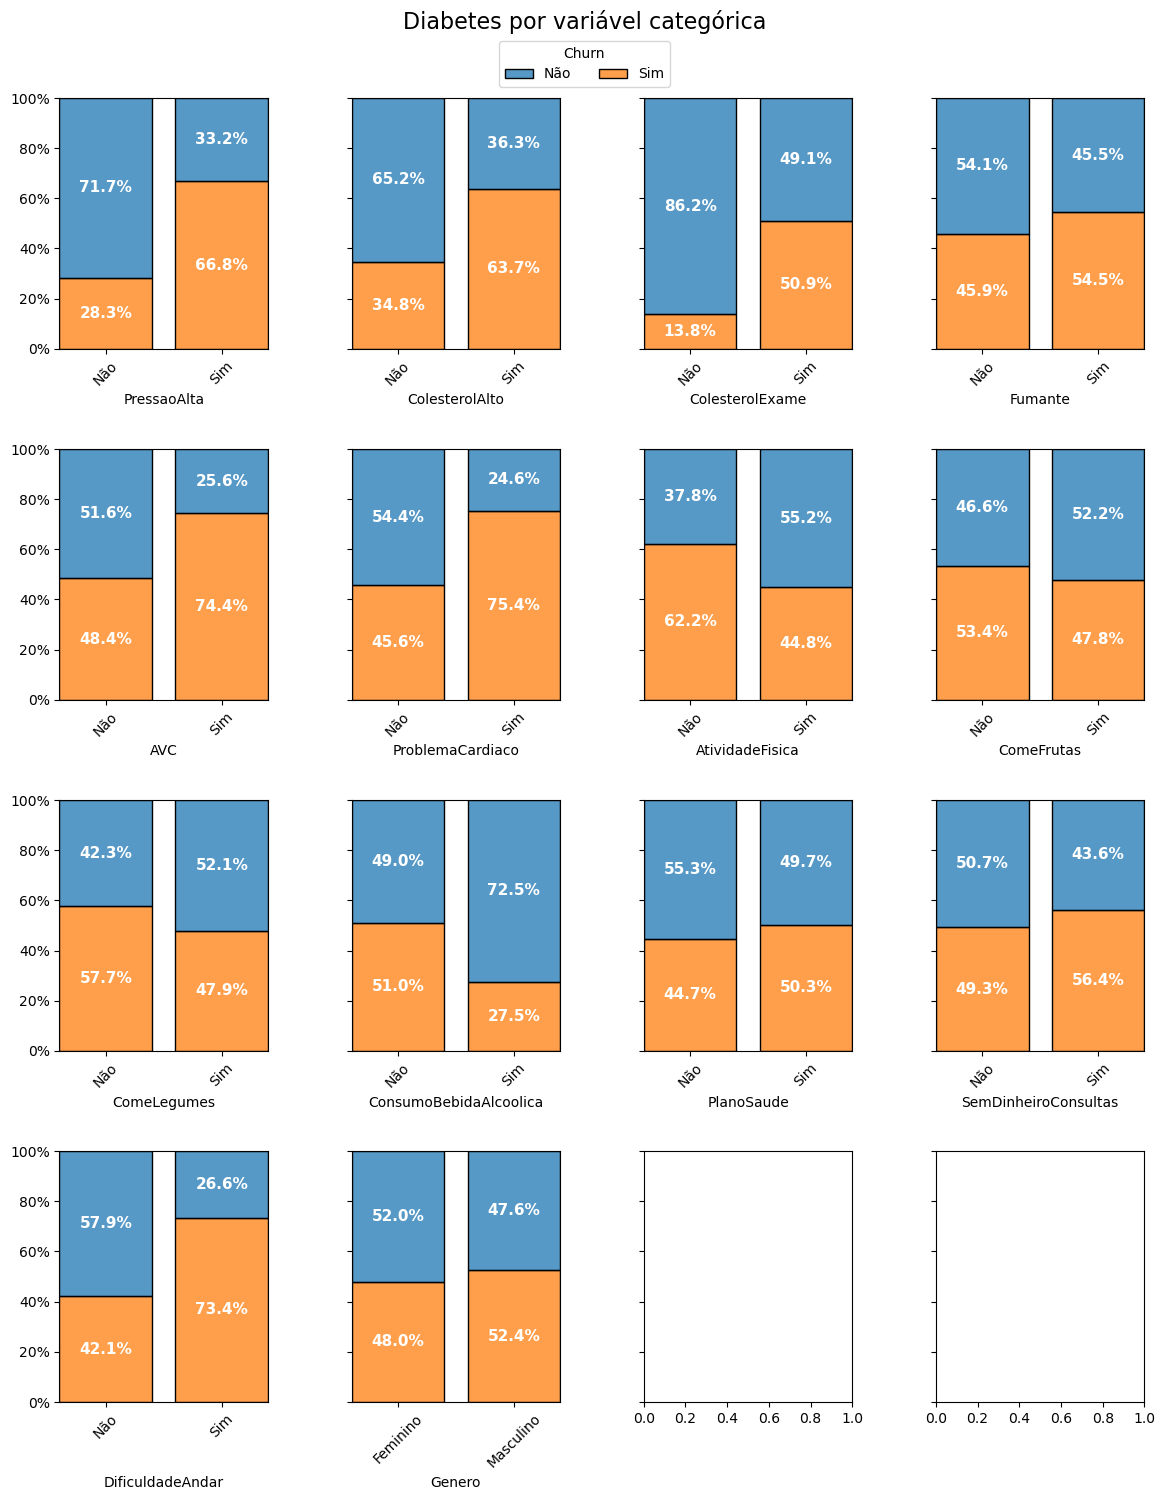

In [33]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(14, 16), sharey=True)

for i, coluna in enumerate(colunas_binarias):
    h = sns.histplot(x=coluna, hue='Diabetes',
                     data=df_diabetes_tratado,
                     multiple='fill',
                     ax=axs.flat[i], stat='percent',
                     shrink=0.8)
    h.tick_params(axis='x', labelrotation=45)
    h.grid(False)

    h.yaxis.set_major_formatter(PercentFormatter(1))
    h.set_ylabel('')

    for bar in h.containers:
        h.bar_label(bar,
                    label_type='center',
                    labels=[f'{b.get_height():.1%}' for b in bar],
                    color='white',
                    weight='bold', fontsize=11)

    legend = h.get_legend()
    legend.remove()

labels = [text.get_text() for text in legend.get_texts()]

fig.legend(handles=legend.legend_handles,
           labels=labels, loc='upper center',
           ncols=2, title='Churn',
           bbox_to_anchor=(0.5, 0.965))
fig.suptitle('Diabetes por variável categórica', fontsize=16)

fig.align_labels()

plt.subplots_adjust(wspace=0.4, hspace=0.4, top=0.925)

plt.show()

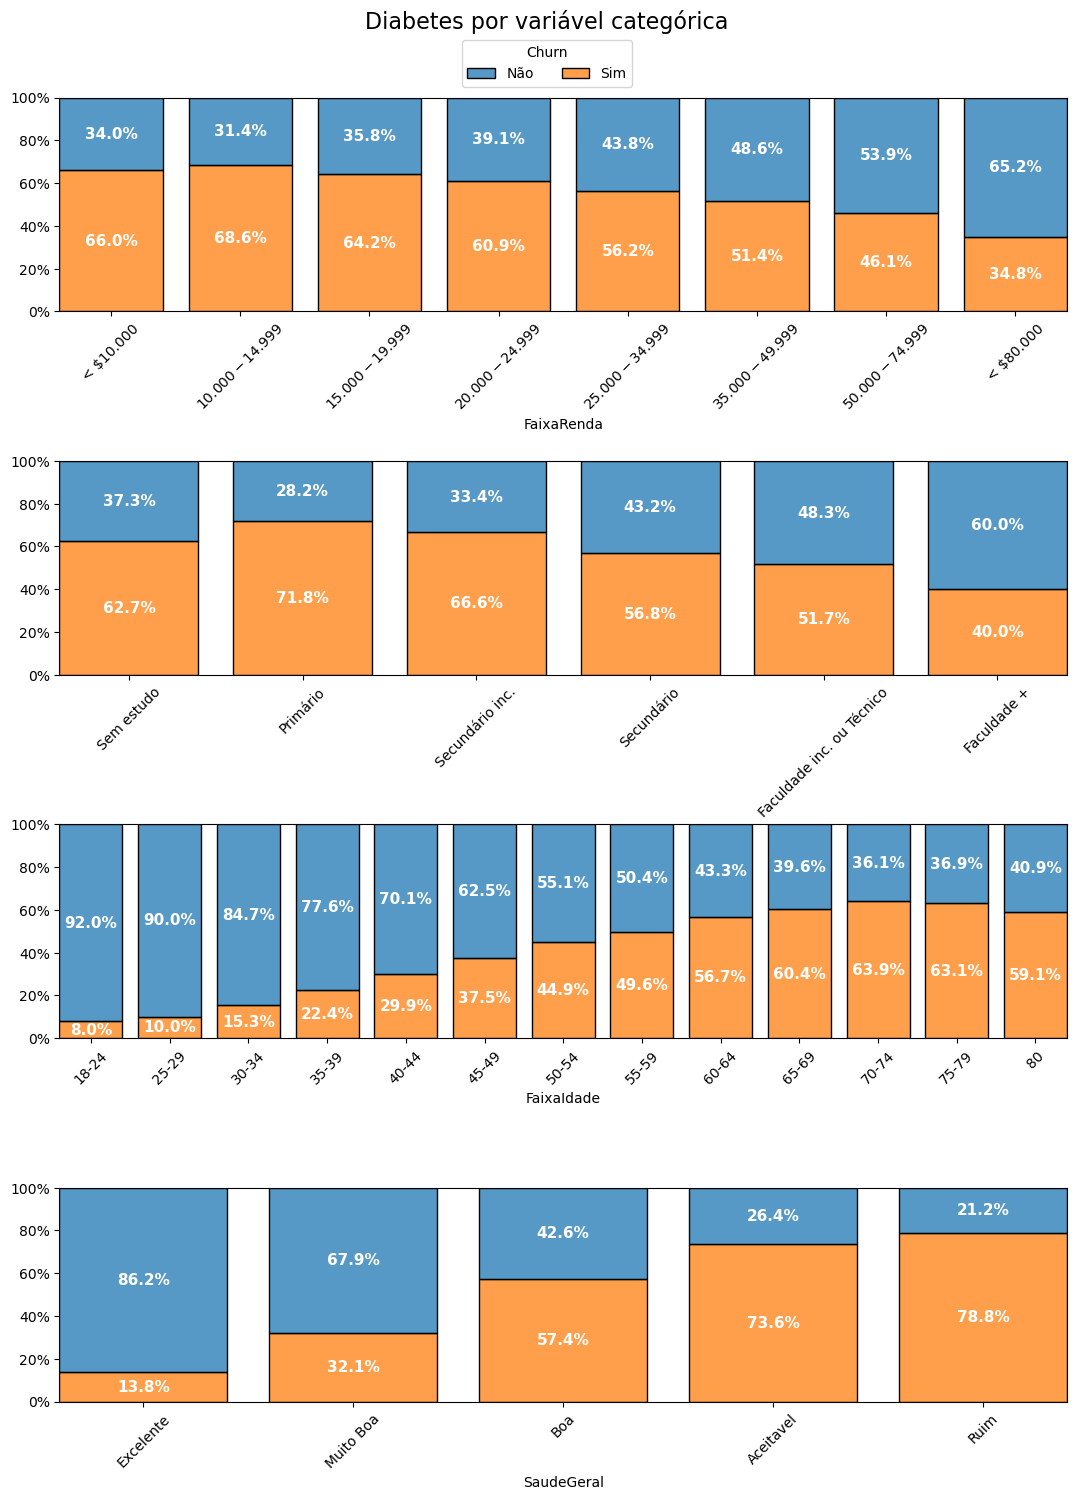

In [34]:
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(13, 16),)

for i, coluna in enumerate(colunas_nao_binarias):
    h = sns.histplot(x=coluna, hue='Diabetes',
                     data=df_diabetes_tratado,
                     multiple='fill',
                     ax=axs.flat[i], stat='percent',
                     shrink=0.8)
    h.tick_params(axis='x', labelrotation=45)
    h.grid(False)

    h.yaxis.set_major_formatter(PercentFormatter(1))
    h.set_ylabel('')

    for bar in h.containers:
        h.bar_label(bar,
                    label_type='center',
                    labels=[f'{b.get_height():.1%}' for b in bar],
                    color='white',
                    weight='bold', fontsize=11)

    legend = h.get_legend()
    legend.remove()

labels = [text.get_text() for text in legend.get_texts()]

fig.legend(handles=legend.legend_handles,
           labels=labels, loc='upper center',
           ncols=2, title='Churn',
           bbox_to_anchor=(0.5, 0.965))
fig.suptitle('Diabetes por variável categórica', fontsize=16)

fig.align_labels()

plt.subplots_adjust(wspace=0.2, hspace=0.7, top=0.925)

plt.show()

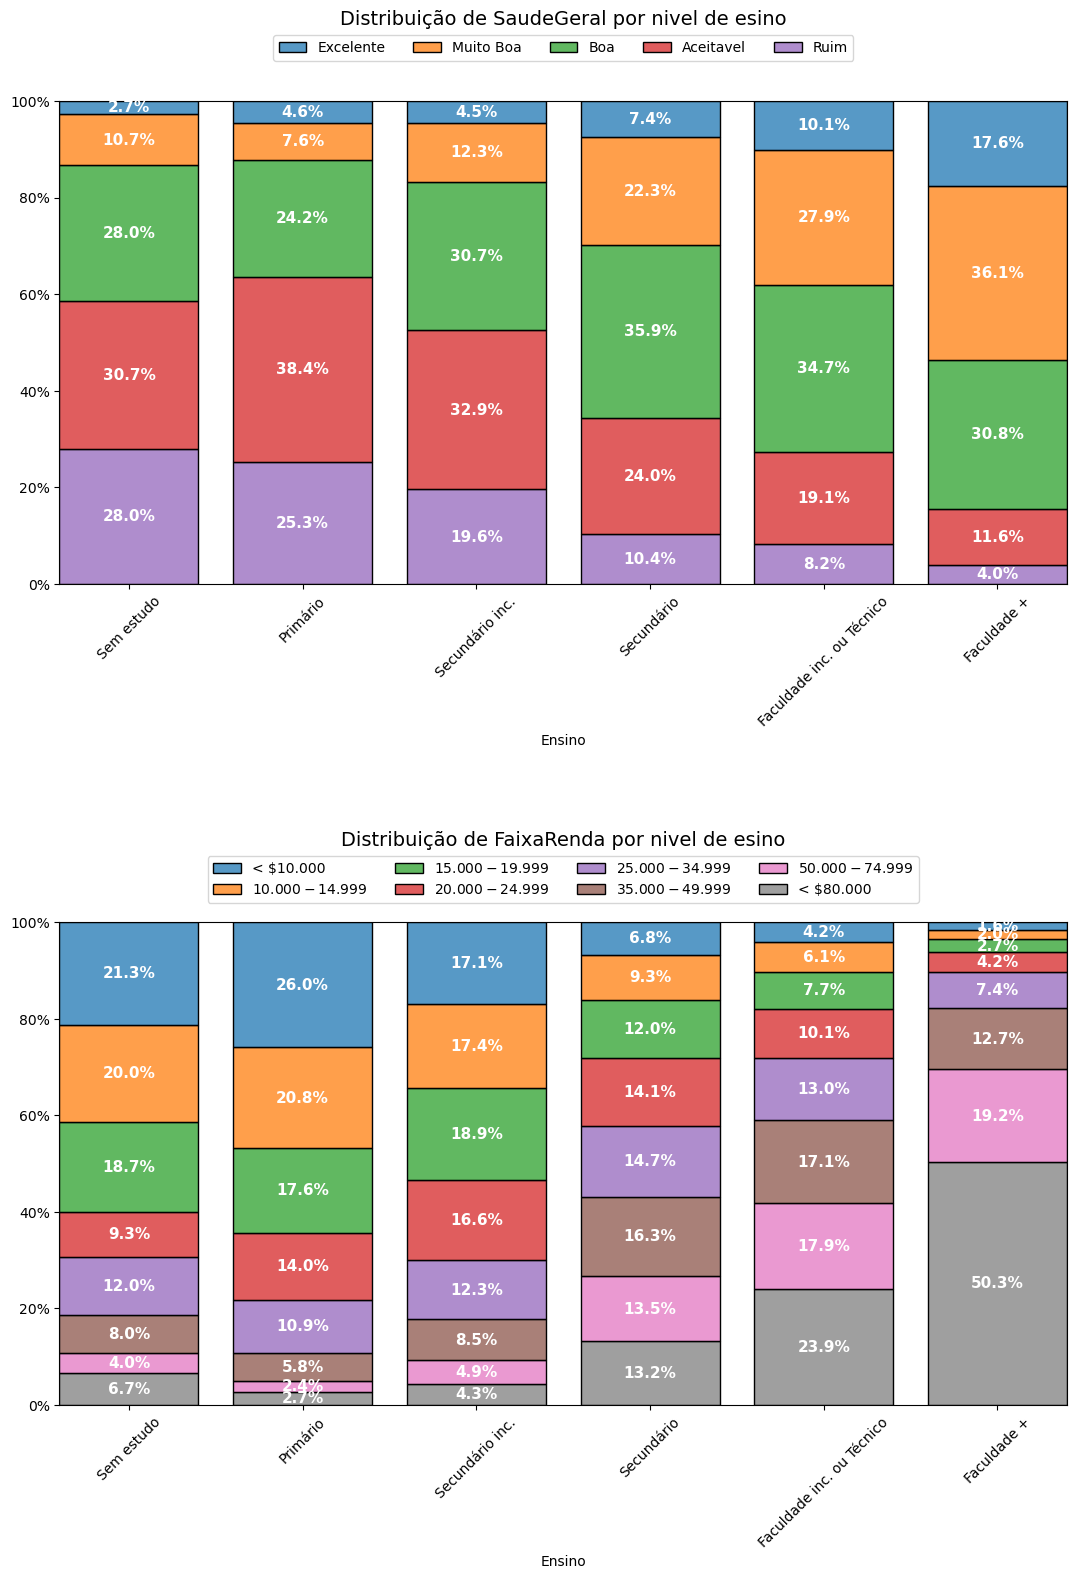

In [35]:
colunas_analises = ["SaudeGeral", "FaixaRenda"]

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(13, 16),)

for ax, coluna in zip(axs.flatten(), colunas_analises):
    h = sns.histplot(x="Ensino",
                     hue=coluna,
                     data=df_diabetes_tratado,
                     multiple='fill',
                     ax=ax,
                     shrink=0.8)
    h.tick_params(axis='x', labelrotation=45)
    h.grid(False)

    h.yaxis.set_major_formatter(PercentFormatter(1))
    h.set_ylabel('')

    for bar in h.containers:
        h.bar_label(bar,
                    label_type='center',
                    labels=[f'{b.get_height():.1%}' for b in bar],
                    color='white',
                    weight='bold', fontsize=11)

    legend = h.get_legend()
    #legend.remove()

    labels = [text.get_text() for text in legend.get_texts()]

    numero_itens = len(df_diabetes_tratado[coluna].cat.categories)

    ax.legend(
        handles=legend.legend_handles,
        labels=labels,
        loc="upper center",
        ncols=numero_itens if numero_itens <= 6 else min(4, numero_itens),
        bbox_to_anchor=(0.5, 1.15),
    )

    ax.set_title(f"Distribuição de {coluna} por nivel de esino", fontsize=14, pad=55)




# fig.legend(handles=legend.legend_handles,
#            labels=labels, loc='upper center',
#            ncols=2, title='Churn',
#            bbox_to_anchor=(0.5, 0.965))
# fig.suptitle('Diabetes por variável categórica', fontsize=16)

# fig.align_labels()

plt.subplots_adjust(wspace=0.1, hspace=0.7, top=0.925)

plt.show()

In [36]:
tabelas_contigencia = {}

for coluna in df_diabetes_tratado.select_dtypes("category").columns:
    if coluna != coluna_alvo:
        tabelas_contigencia[coluna] = pd.crosstab(df_diabetes_tratado[coluna_alvo], df_diabetes_tratado[coluna])

In [37]:
tabelas_contigencia["PressaoAlta"]

PressaoAlta,Não,Sim
Diabetes,,
Não,22118,13228
Sim,8742,26604


In [38]:
for coluna in df_diabetes_tratado.select_dtypes("category").columns:
    if coluna != coluna_alvo:
        display(
            pd.crosstab(
                df_diabetes_tratado[coluna_alvo],
                df_diabetes_tratado[coluna],
                margins=True,
                normalize="index"
            ).style.format("{:.2%}")
        )

PressaoAlta,Não,Sim
Diabetes,,
Não,62.58%,37.42%
Sim,24.73%,75.27%
All,43.65%,56.35%


ColesterolAlto,Não,Sim
Diabetes,,
Não,61.87%,38.13%
Sim,32.99%,67.01%
All,47.43%,52.57%


ColesterolExame,Não,Sim
Diabetes,,
Não,4.27%,95.73%
Sim,0.68%,99.32%
All,2.47%,97.53%


Fumante,Não,Sim
Diabetes,,
Não,56.77%,43.23%
Sim,48.18%,51.82%
All,52.47%,47.53%


AVC,Não,Sim
Diabetes,,
Não,96.81%,3.19%
Sim,90.75%,9.25%
All,93.78%,6.22%


ProblemaCardiaco,Não,Sim
Diabetes,,
Não,92.73%,7.27%
Sim,77.71%,22.29%
All,85.22%,14.78%


AtividadeFisica,Não,Sim
Diabetes,,
Não,22.45%,77.55%
Sim,36.95%,63.05%
All,29.70%,70.30%


ComeFrutas,Não,Sim
Diabetes,,
Não,36.19%,63.81%
Sim,41.46%,58.54%
All,38.82%,61.18%


ComeLegumes,Não,Sim
Diabetes,,
Não,17.89%,82.11%
Sim,24.36%,75.64%
All,21.12%,78.88%


ConsumoBebidaAlcoolica,Não,Sim
Diabetes,,
Não,93.81%,6.19%
Sim,97.65%,2.35%
All,95.73%,4.27%


PlanoSaude,Não,Sim
Diabetes,,
Não,4.99%,95.01%
Sim,4.02%,95.98%
All,4.50%,95.50%


SemDinheiroConsultas,Não,Sim
Diabetes,,
Não,91.80%,8.20%
Sim,89.41%,10.59%
All,90.61%,9.39%


SaudeGeral,Excelente,Muito Boa,Boa,Aceitavel,Ruim
Diabetes,,,,,
Não,20.21%,38.17%,28.21%,9.94%,3.48%
Sim,3.23%,18.05%,38.07%,27.70%,12.95%
All,11.72%,28.11%,33.14%,18.82%,8.22%


DificuldadeAndar,Não,Sim
Diabetes,,
Não,86.58%,13.42%
Sim,62.88%,37.12%
All,74.73%,25.27%


Genero,Feminino,Masculino
Diabetes,,
Não,56.51%,43.49%
Sim,52.09%,47.91%
All,54.30%,45.70%


FaixaIdade,18-24,25-29,30-34,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80
Diabetes,,,,,,,,,,,,,
Não,2.55%,3.55%,4.91%,6.13%,6.99%,8.22%,10.71%,12.28%,12.39%,12.16%,8.21%,5.63%,6.27%
Sim,0.22%,0.40%,0.89%,1.77%,2.97%,4.93%,8.74%,12.06%,16.22%,18.55%,14.54%,9.63%,9.08%
All,1.38%,1.97%,2.90%,3.95%,4.98%,6.58%,9.72%,12.17%,14.30%,15.36%,11.38%,7.63%,7.68%


Ensino,Sem estudo,Primário,Secundário inc.,Secundário,Faculdade inc. ou Técnico,Faculdade +
Diabetes,,,,,,
Não,0.08%,1.31%,3.26%,23.78%,27.38%,44.19%
Sim,0.13%,3.35%,6.50%,31.31%,29.29%,29.42%
All,0.11%,2.33%,4.88%,27.55%,28.33%,36.81%


FaixaRenda,< $10.000,$10.000-$14.999,$15.000-$19.999,$20.000-$24.999,$25.000-$34.999,$35.000-$49.999,$50.000-$74.999,< $80.000
Diabetes,,,,,,,,
Não,3.47%,3.99%,5.63%,7.37%,9.92%,14.13%,17.43%,38.06%
Sim,6.74%,8.73%,10.09%,11.47%,12.74%,14.97%,14.90%,20.36%
All,5.11%,6.36%,7.86%,9.42%,11.33%,14.55%,16.16%,29.21%


In [39]:
for coluna, tabela in tabelas_contigencia.items():
    chi2, p, _, _ = chi2_contingency(tabela)
    print(f"{coluna} - {chi2} - {p}")

PressaoAlta - 10287.972984997781 - 0.0
ColesterolAlto - 5911.8066998822505 - 0.0
ColesterolExame - 939.6317718798653 - 2.3798712773419562e-206
Fumante - 522.4810772937883 - 1.2211053080400827e-115
AVC - 1111.0793074560897 - 1.290837098922016e-243
ProblemaCardiaco - 3161.7202445322782 - 0.0
AtividadeFisica - 1778.9607035956992 - 0.0
ComeFrutas - 206.50090830615105 - 7.967064756507964e-47
ComeLegumes - 444.0806516898606 - 1.4007103685991128e-98
ConsumoBebidaAlcoolica - 635.0865339749427 - 3.9133962745676324e-140
PlanoSaude - 37.79561046998934 - 7.855833890083924e-10
SemDinheiroConsultas - 118.4167174482265 - 1.4053255735064045e-27
SaudeGeral - 12304.318979903528 - 0.0
DificuldadeAndar - 5253.694843161374 - 0.0
Genero - 139.26185542886512 - 3.860395909809483e-32
FaixaIdade - 6179.057132257292 - 0.0
Ensino - 2132.272551584347 - 0.0
FaixaRenda - 3855.454575562344 - 0.0


In [40]:
resultados_correlacao = df_diabetes_tratado.select_dtypes("category").apply(lambda coluna: coluna.cat.codes).corr(method="spearman", numeric_only=False)

resultados_correlacao

,Diabetes,PressaoAlta,ColesterolAlto,ColesterolExame,Fumante,AVC,ProblemaCardiaco,AtividadeFisica,ComeFrutas,ComeLegumes,ConsumoBebidaAlcoolica,PlanoSaude,SemDinheiroConsultas,SaudeGeral,DificuldadeAndar,Genero,FaixaIdade,Ensino,FaixaRenda
Diabetes,1.000000,0.381516,0.289213,0.115382,0.085999,0.125427,0.211523,-0.158666,-0.054077,-0.079293,-0.094853,0.023191,0.040977,0.414259,0.272646,0.044413,0.261620,-0.169926,-0.232529
PressaoAlta,0.381516,1.000000,0.316515,0.103283,0.087438,0.129060,0.210750,-0.136102,-0.040852,-0.066624,-0.027030,0.035764,0.026517,0.324038,0.234784,0.040819,0.322180,-0.143543,-0.196896
ColesterolAlto,0.289213,0.316515,1.000000,0.085981,0.093398,0.099786,0.181187,-0.090453,-0.047384,-0.042836,-0.025443,0.031532,0.033199,0.239138,0.162043,0.017324,0.217974,-0.083177,-0.110289
ColesterolExame,0.115382,0.103283,0.085981,1.000000,-0.004331,0.022529,0.043497,-0.008249,0.017384,0.000349,-0.027146,0.106800,-0.062669,0.060257,0.044430,-0.007991,0.099208,-0.007693,0.007271
Fumante,0.085999,0.087438,0.093398,-0.004331,1.000000,0.064658,0.124418,-0.079823,-0.074811,-0.029926,0.077835,-0.012939,0.035799,0.149960,0.119789,0.112125,0.098822,-0.152918,-0.112241
AVC,0.125427,0.129060,0.099786,0.022529,0.064658,1.000000,0.223394,-0.079985,-0.008996,-0.047601,-0.023395,0.006484,0.036198,0.182517,0.192266,0.003822,0.123544,-0.071889,-0.134487
ProblemaCardiaco,0.211523,0.210750,0.181187,0.043497,0.124418,0.223394,1.000000,-0.098223,-0.019436,-0.036315,-0.037130,0.015687,0.036029,0.268815,0.232611,0.098161,0.225231,-0.093727,-0.148924
AtividadeFisica,-0.158666,-0.136102,-0.090453,-0.008249,-0.079823,-0.079985,-0.098223,1.000000,0.133813,0.149322,0.019111,0.027089,-0.063302,-0.270967,-0.276868,0.051753,-0.092685,0.193831,0.202370
ComeFrutas,-0.054077,-0.040852,-0.047384,0.017384,-0.074811,-0.008996,-0.019436,0.133813,1.000000,0.238605,-0.033246,0.029385,-0.045843,-0.099559,-0.050784,-0.088723,0.067778,0.104653,0.076732
ComeLegumes,-0.079293,-0.066624,-0.042836,0.000349,-0.029926,-0.047601,-0.036315,0.149322,0.238605,1.000000,0.022090,0.029152,-0.037146,-0.117258,-0.084072,-0.052604,-0.017208,0.153539,0.155816


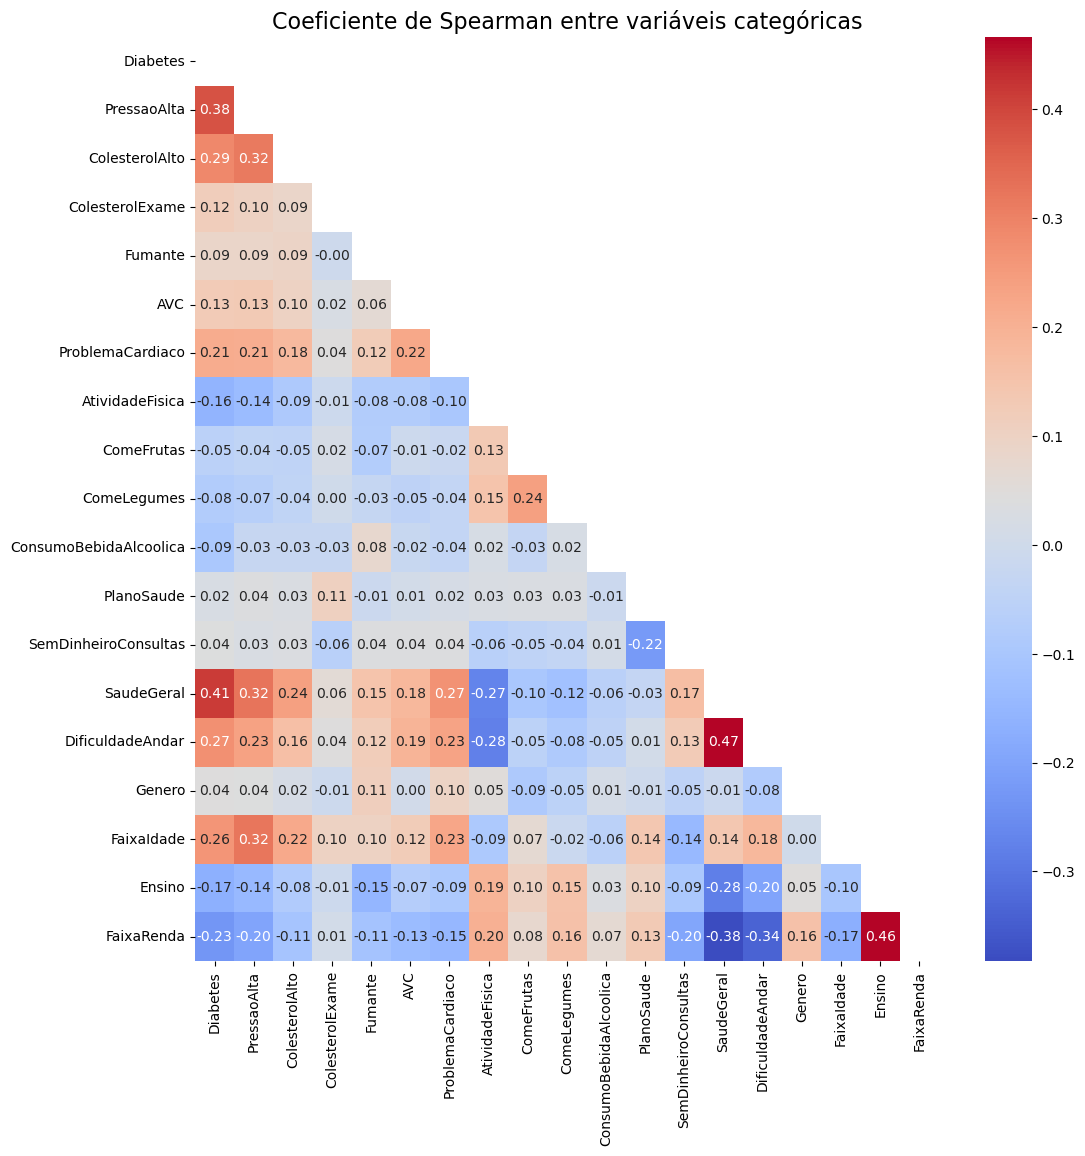

In [41]:
matriz = np.triu(resultados_correlacao)

fig, ax = plt.subplots(figsize=(12, 12))

sns.heatmap(resultados_correlacao, mask=matriz, annot=True, fmt=".2f", ax=ax, cmap="coolwarm")

plt.title("Coeficiente de Spearman entre variáveis categóricas", fontsize=16)

plt.show()